In [23]:
import moth
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import csv
import scipy
import scipy.signal
import h5py
import pathlib

PATH = '/storage/home/adz6/group/project'
DIGDATAPATH = os.path.join(PATH, 'datasets', 'data', 'lab', 'dig')
#DAQDATAPATH = os.path.join(PATH, 'daq_data')
#MOTHPATH = os.path.join(PATH, 'moth')
#MOTHDATA = os.path.join(MOTHPATH, 'data/datasets')
#PLOTPATH = os.path.join(PATH, 'plots/moth')
#MOTHRESULTS = os.path.join(PATH, 'results/moth')
sns.set_theme(context='talk')

def nearfield_correction(x, a, phi):
    
    return a * np.cos(2 * np.pi * x / np.pi + phi)


#def AnalyzePhase(array_data, xpos, ypos, nch, ideal_x)

def SumData(array_data, xpos, ypos, nch, ideal_x,  r=0.1, f=25.8e9, antispiral=False):
    
    xx, yy = np.meshgrid(xpos, ypos)
    array_antenna_theta = np.arange(0, 2 * np.pi, 2 * np.pi / array_data.shape[0])
    
    xantenna = (r * np.cos(-1 * array_antenna_theta)).reshape((array_antenna_theta.size, 1, 1))
    yantenna = (r * np.sin(-1 * array_antenna_theta)).reshape((array_antenna_theta.size, 1, 1))
    
    xdist = xantenna - xx.reshape((1, *xx.shape))
    ydist = yantenna - yy.reshape((1, *yy.shape))
    
    dist_grid = np.sqrt(xdist ** 2 + ydist ** 2)
    
    ind_max = np.argmax(abs(np.fft.fft(array_data[:, nch, :], axis=-1)), axis=-1)[0]
    
    #print(np.angle(np.fft.fft(array_data[:, nch, :], axis=-1))[:, ind_max])
    
    zero = np.angle(np.fft.fft(array_data[:, nch, :], axis=-1))[0, ind_max]
    
    #ideal_antispiral = np.linspace(0, 2 * np.pi, 60)
    ideal_antispiral = -np.arctan2(r * np.sin(-1 * array_antenna_theta), r * np.cos(-1 * array_antenna_theta) - ideal_x)
    #ideal_x = 0.025
    ideal_y = 0.0
    
    ideal_distances = np.sqrt(
        (r * np.cos(-1 * array_antenna_theta) - ideal_x) ** 2
        + (r * np.sin(-1 * array_antenna_theta) - ideal_y) ** 2
    )
    
    ideal_phases =  np.unwrap(np.roll(2 * np.pi * ideal_distances * f / 3e8 - 1 * ideal_antispiral, -15)) 
    #ideal_phases -= (zero + ideal_phases[0])
    
    array_phases = np.unwrap(np.angle(np.fft.fft(array_data[:, nch, :], axis=-1))[:, ind_max])
    array_mags = abs(np.fft.fft(array_data[:, nch, :], axis=-1))[:, ind_max]
    ideal_phases -= (ideal_phases[0] - array_phases[0])
    ideal_phases += 0 * np.pi/4
    
    difference = ideal_phases - array_phases
    
    fig = plt.figure(figsize=(13, 8))
    ax = fig.add_subplot(1,1,1)
    
    ax.plot(np.unwrap(np.angle(np.fft.fft(array_data[:, nch, :], axis=-1))[:, ind_max]))
    ax.plot(ideal_phases)
    ax.plot()
    plt.show()
    
    #fig = plt.figure(figsize=(13, 8))
    #ax = fig.add_subplot(1,1,1)
    
    #ax.plot(array_phases)
    #ax.plot(ideal_phases)
    #ax.plot(difference - np.mean(difference))
    
    popt, pcov = scipy.optimize.curve_fit(
        nearfield_correction,
        np.arange(0, 60, 1) * np.pi/30,
        difference - np.mean(difference),
        [0.5,0.045]
    )
    
    #ax.plot(nearfield_correction(np.arange(0, 60, 1) * np.pi/30, *popt))
    
    #print(popt)
    #ax.plot(np.unwrap(np.angle(np.fft.fft(array_data[:, nch, :], axis=-1))[:, ind_max] - np.roll(diff, 15)))
    
    #plt.show()
    
    #fig = plt.figure(figsize=(13, 8))
    #ax = fig.add_subplot(1,1,1)
    #ax.plot(10*np.log10(array_mags))
    #ax.set_ylim(-10,5)
    #plt.show()
    
    
    difference = nearfield_correction(np.arange(0, 60, 1) * np.pi/30, *popt) + np.mean(difference)
    
    #xx, yy = np.expand_dims(xx, axis=0).repeat(array_data['angle'].size, axis=0), np.expand_dims(yy, axis=0).repeat(array_data['angle'].size, axis=0)

    
    amplitude_weight = 1 #/ dist_grid
    #amplitude_weight = amplitude_weight * (array_antenna_theta.size / amplitude_weight.sum(axis=0)).reshape((1, amplitude_weight.shape[1], amplitude_weight.shape[2]))

    beamforming_phases = np.exp(-1j * 2 * np.pi * dist_grid * f / 3e8)
    
    if antispiral:
        
        #grid_angles = np.arctan2(ydist, xdist)
        
        #antispiral_phase = np.exp(-1j * grid_angles)
        antispiral_phase = np.exp(-1j *  
                                  (-1 * array_antenna_theta - 1 * difference)
                                 ).reshape((60, 1, 1))
        #antispiral_phase = np.exp(-1j * 
        #                          (array_antenna_theta + diff)
        #                         ).reshape((60, 1, 1))
        
        
        return np.matmul((amplitude_weight * beamforming_phases * antispiral_phase).T, array_data[:, nch, :]), popt
    else:
        return np.matmul((amplitude_weight * beamforming_phases).T, array_data[:, nch, :])



In [2]:
os.listdir(DIGDATAPATH)

['211213_cres2_meas_3ch_debug.h5',
 '211202_cres2_3ch_horn_offaxis_sweep.h5',
 '211213_cres2_meas_3ch.h5',
 '211213_cres2_meas_3ch_10slot.h5']

In [3]:
file = h5py.File(os.path.join(DIGDATAPATH, '211213_cres2_meas_3ch.h5'))

In [4]:
file['range3cm_step1mm_z0mm'].keys()

<KeysViewHDF5 ['0', '1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '4', '5', '6', '7', '8', '9', 'lo_f', 'step', 'z']>

In [5]:
file['range3cm_step1mm_z0mm']['10'].shape

(120, 4, 32758)

# combine signals

In [6]:
file['range3cm_step1mm_z0mm'].keys()

<KeysViewHDF5 ['0', '1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '4', '5', '6', '7', '8', '9', 'lo_f', 'step', 'z']>

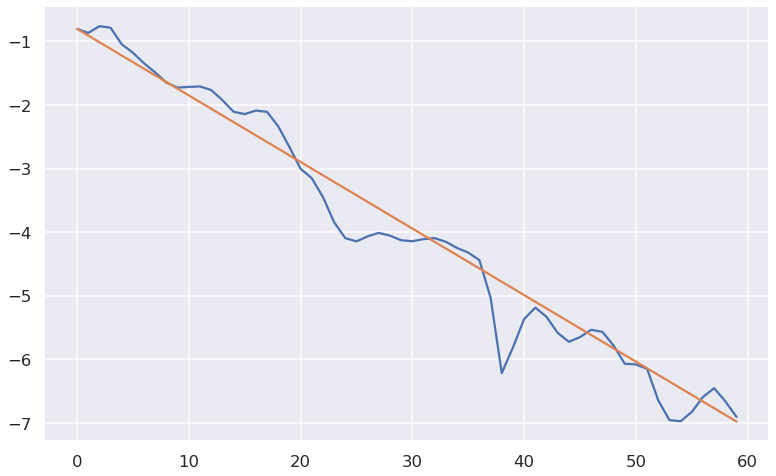

0.0 0.001 0.0


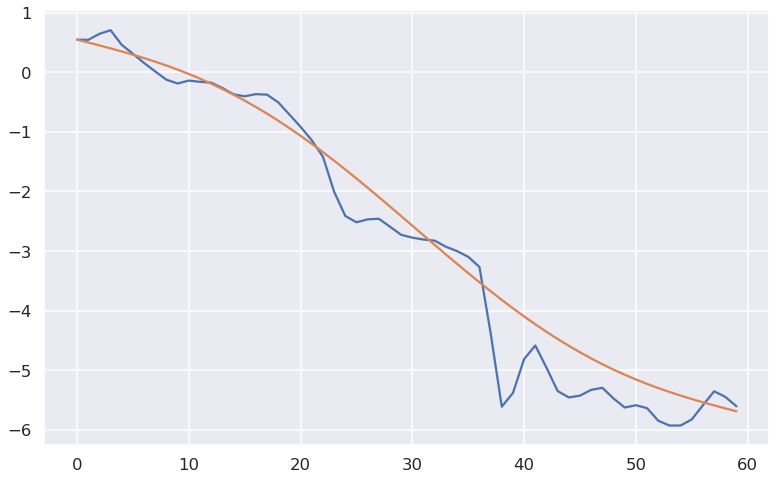

0.0 0.001 0.001


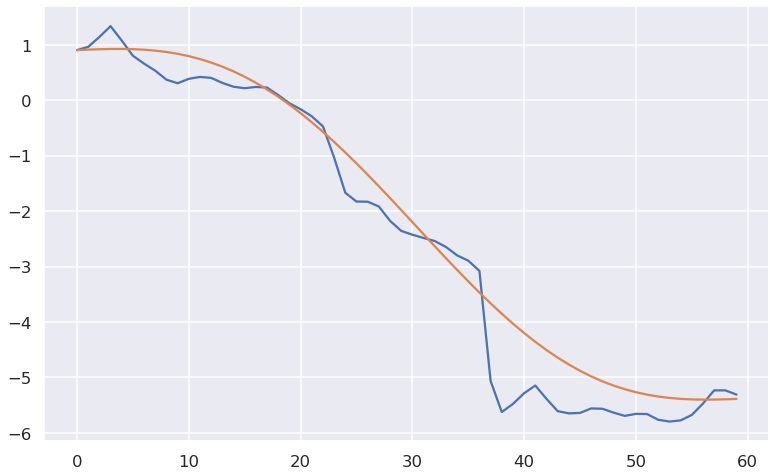

0.0 0.00375 0.002


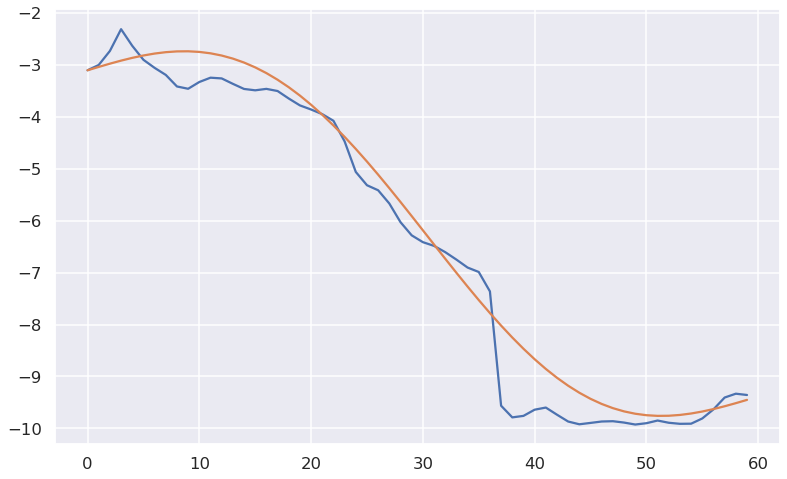

0.0 0.00375 0.003


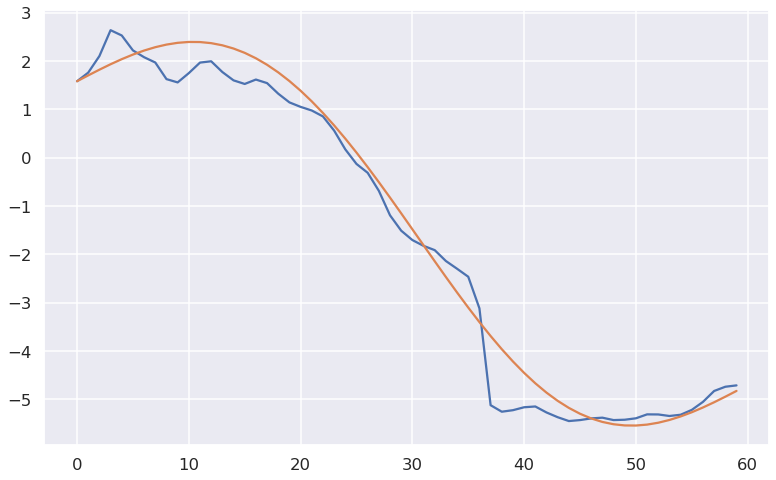

0.0 0.00375 0.004


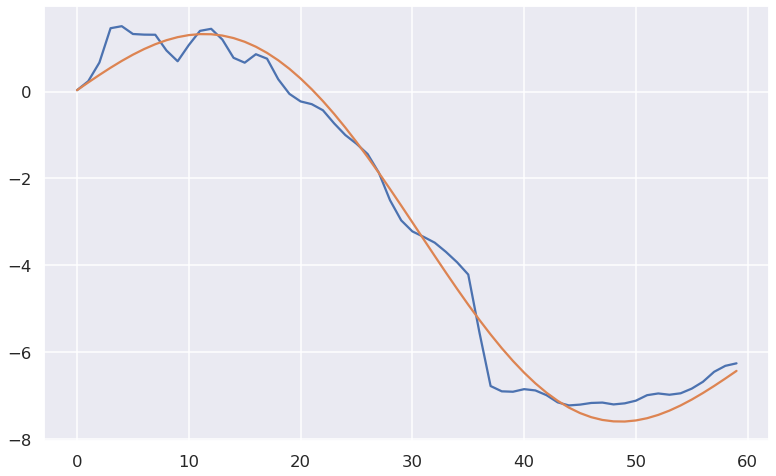

0.0 0.00375 0.005


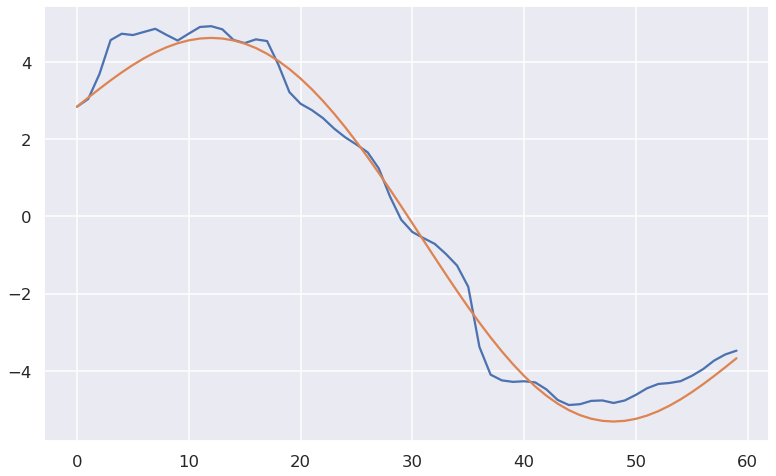

-0.001 0.0065 0.006


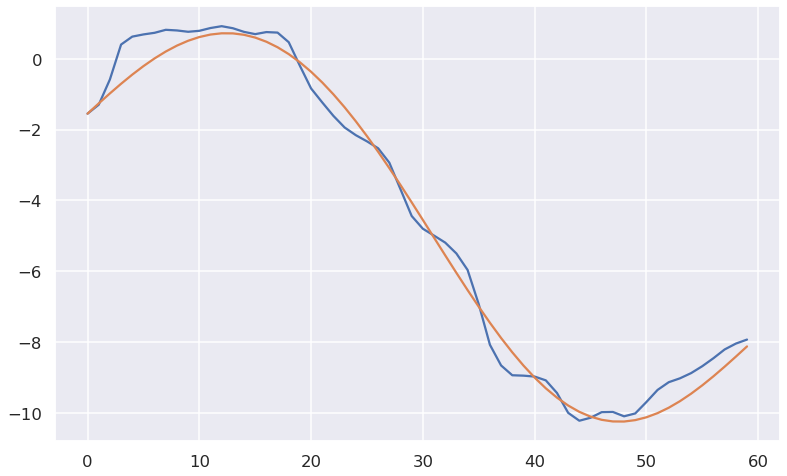

0.0 0.0065 0.007


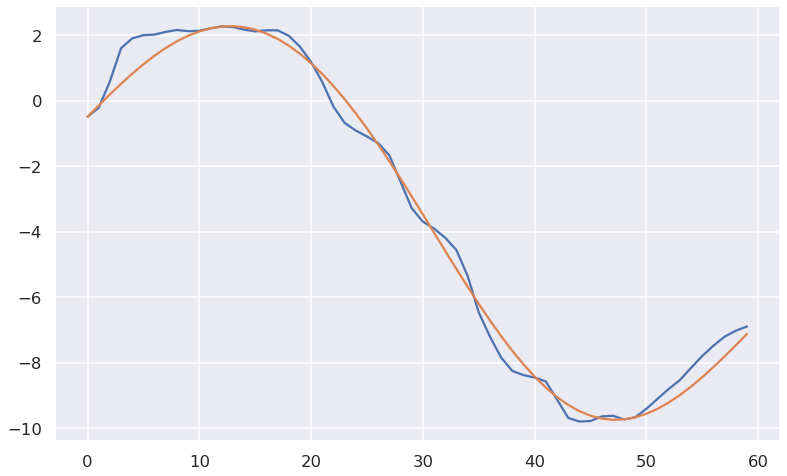

-0.001 0.00925 0.008


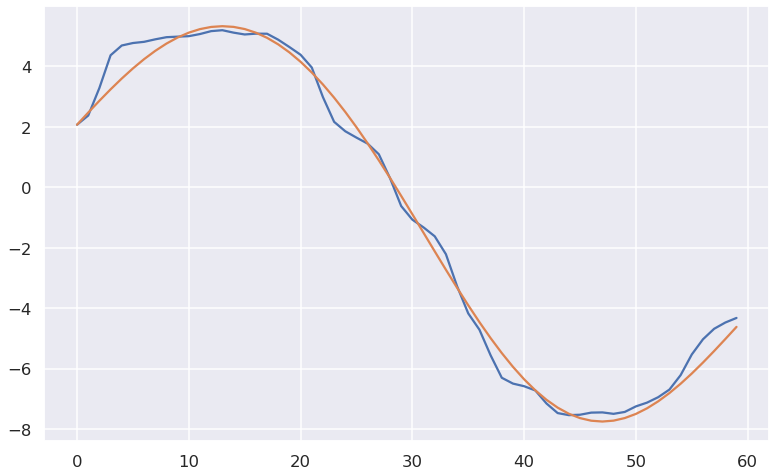

0.0 0.00925 0.009000000000000001


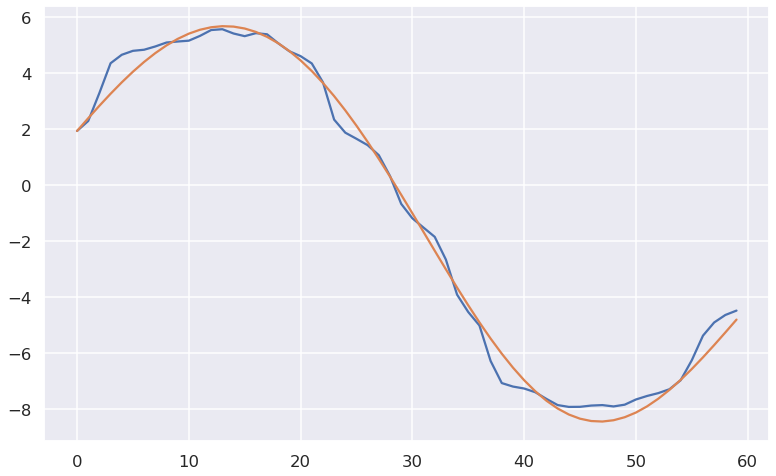

0.0 0.00925 0.01


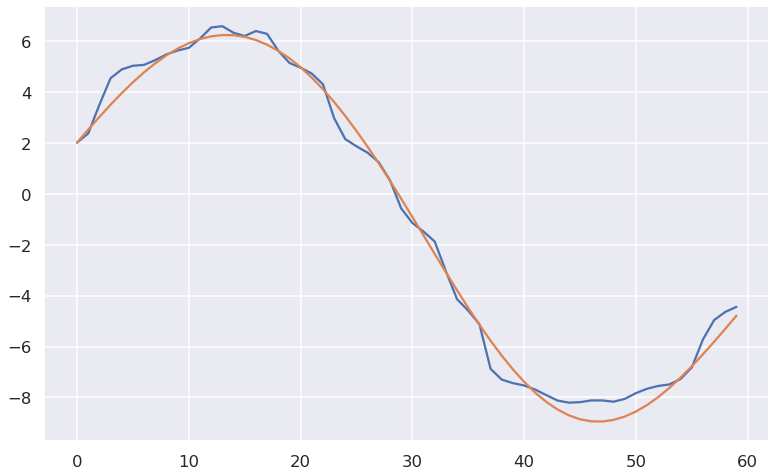

-0.001 0.012 0.011


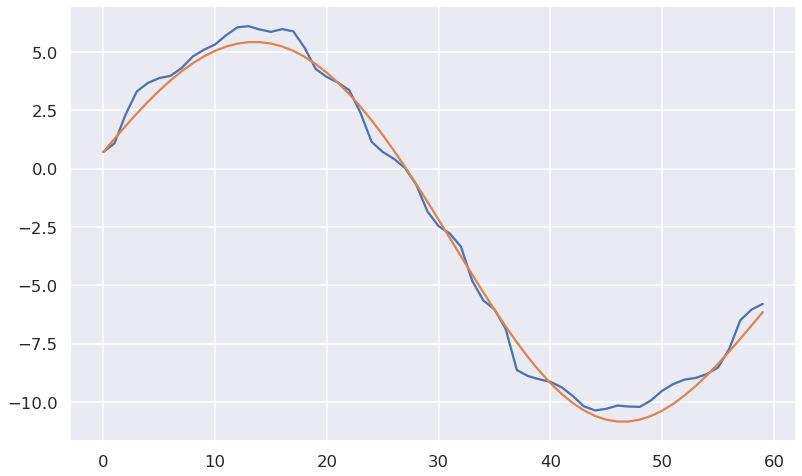

0.0 0.012 0.012


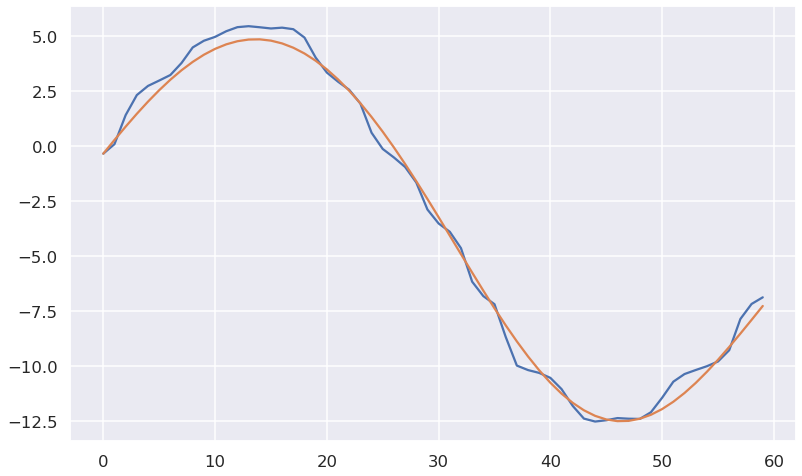

-0.001 0.01475 0.013000000000000001


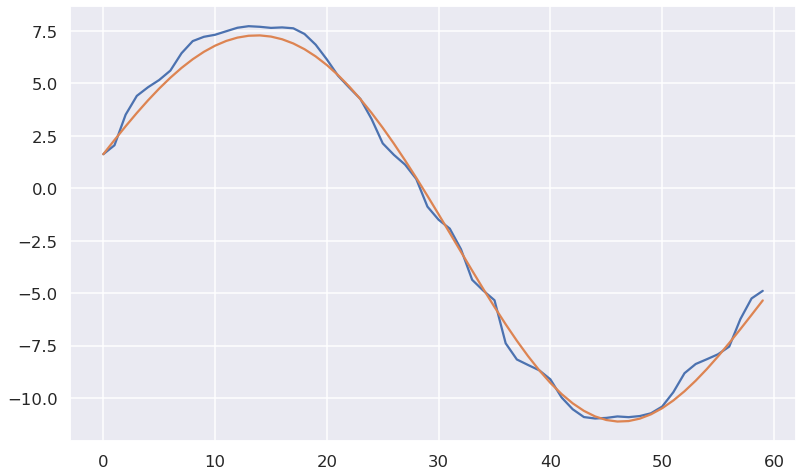

0.0 0.01475 0.014


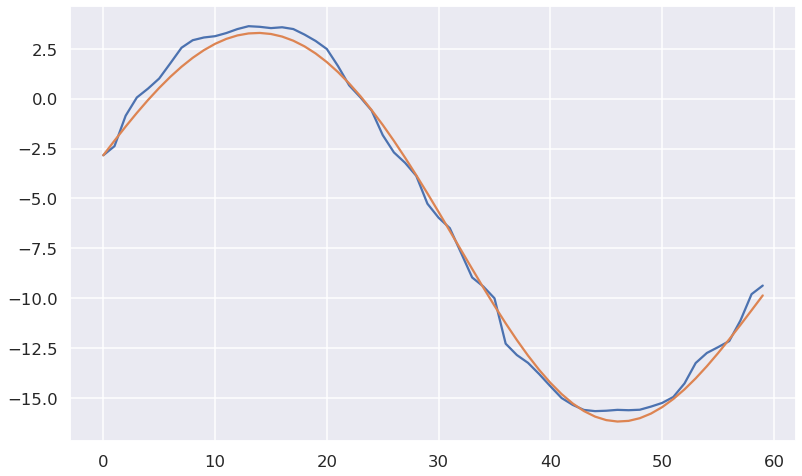

0.0 0.01475 0.015


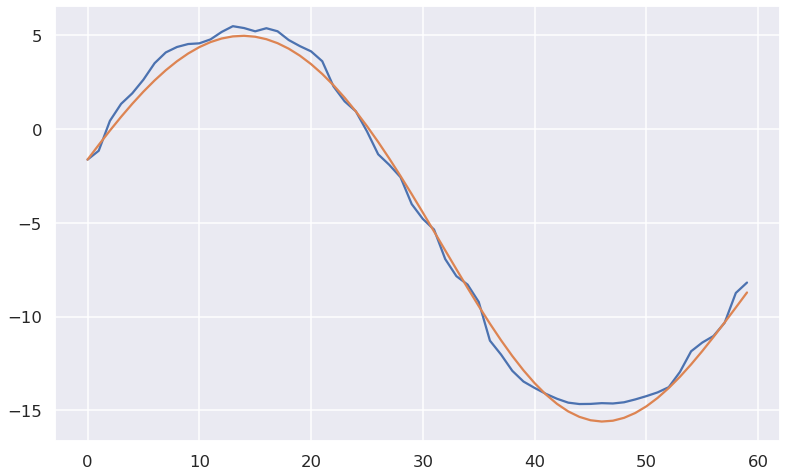

0.0 0.01475 0.016


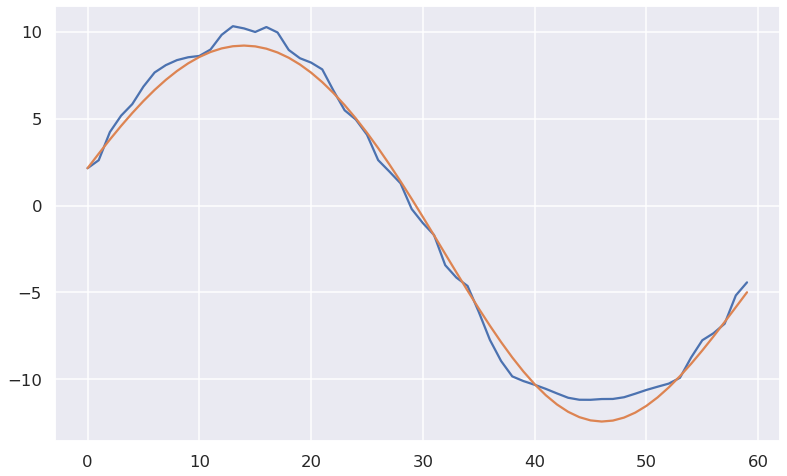

0.0 0.0175 0.017


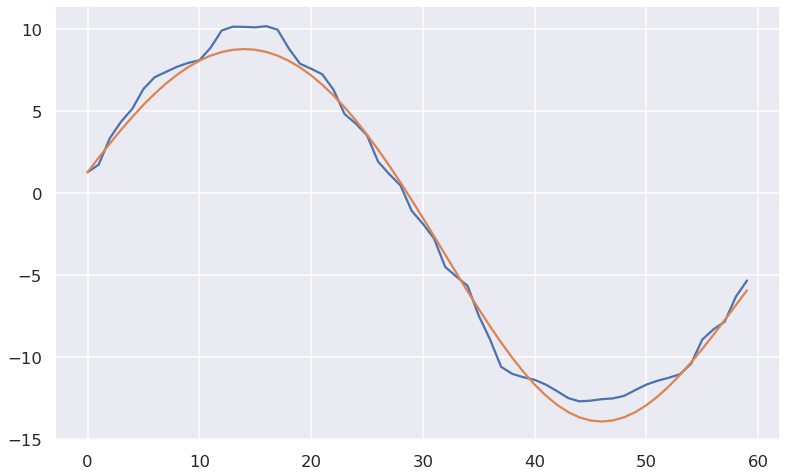

0.0 0.0175 0.018000000000000002


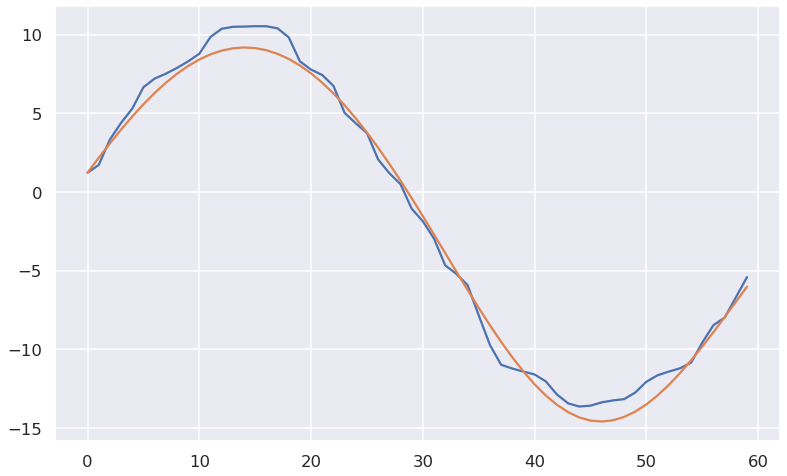

-0.001 0.02025 0.019


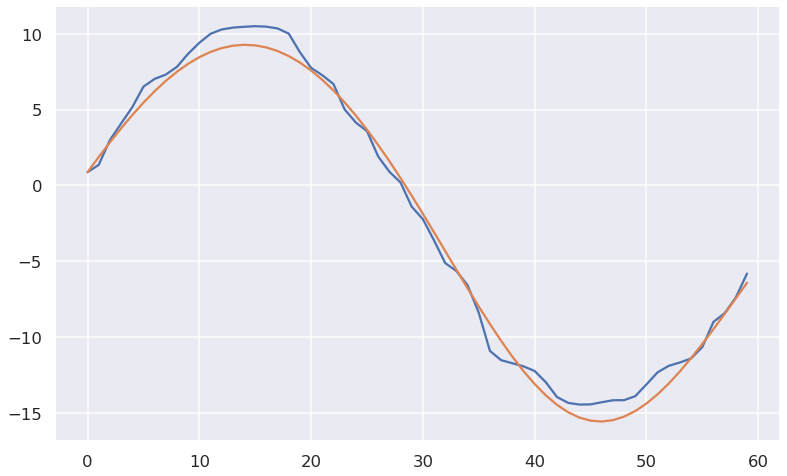

0.0 0.02025 0.02


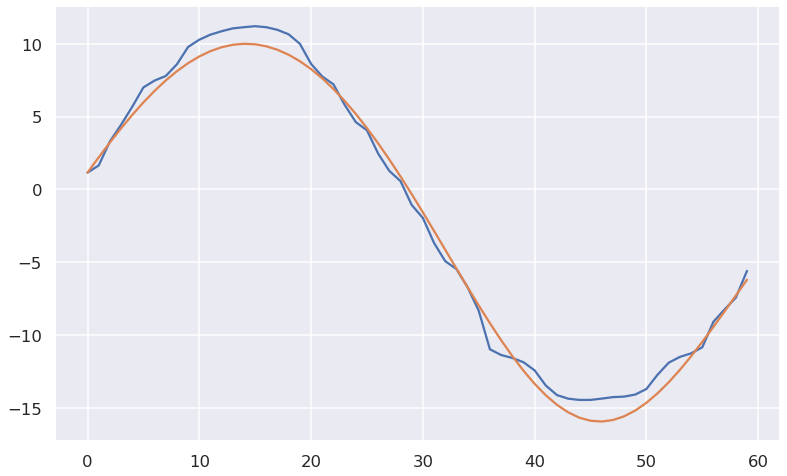

0.0 0.02025 0.021


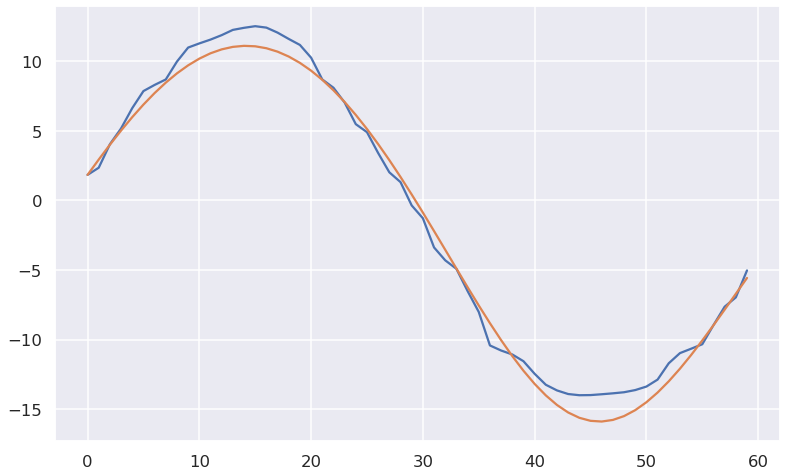

-0.001 0.023 0.022


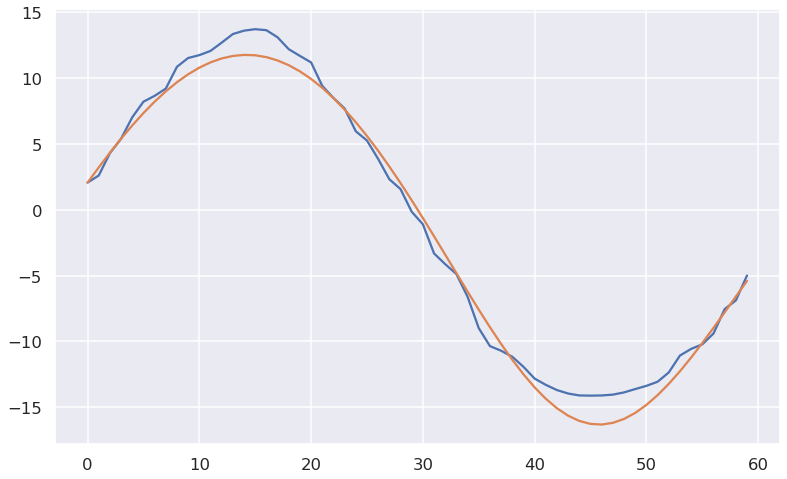

0.0 0.023 0.023


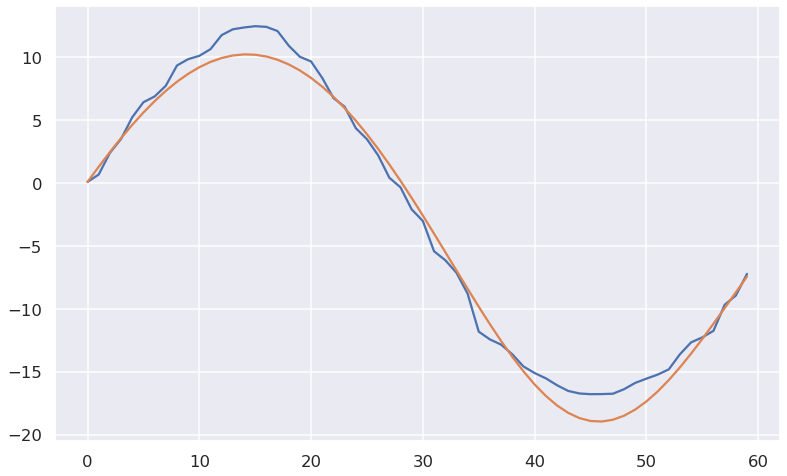

0.0 0.023 0.024


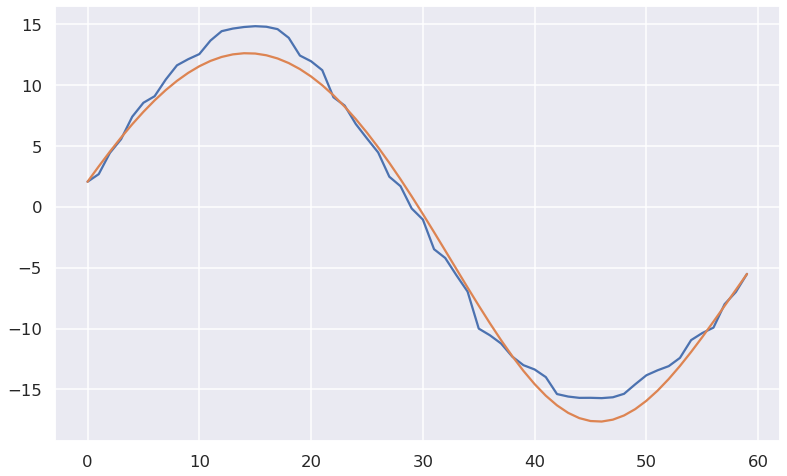

-0.001 0.02575 0.025


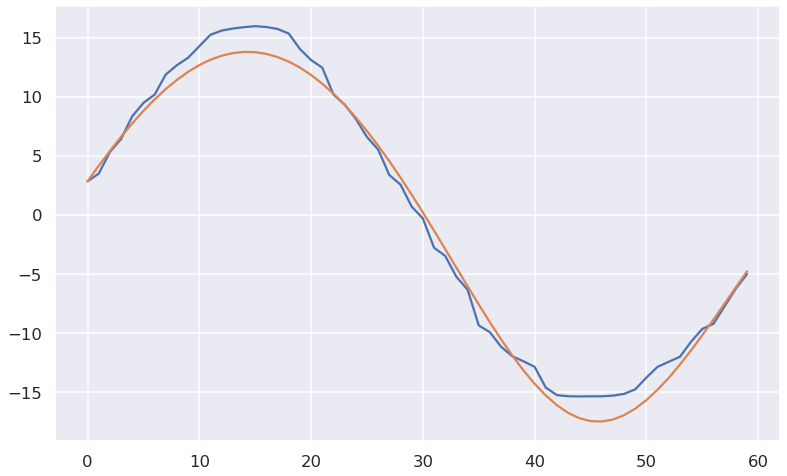

0.0 0.02575 0.026000000000000002


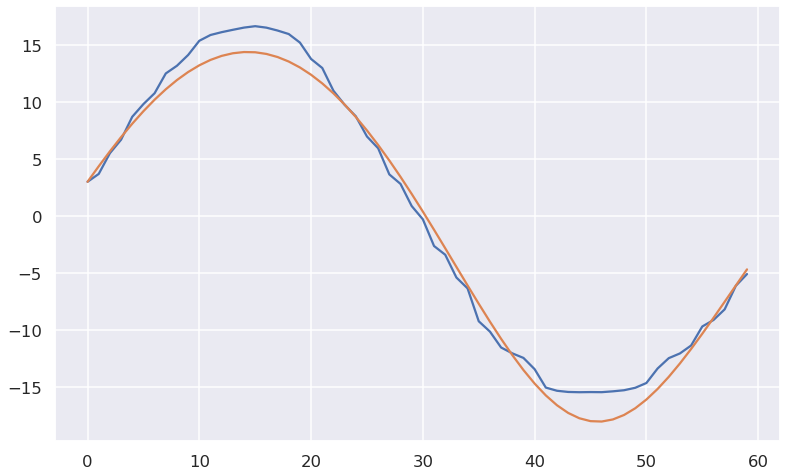

-0.001 0.0285 0.027


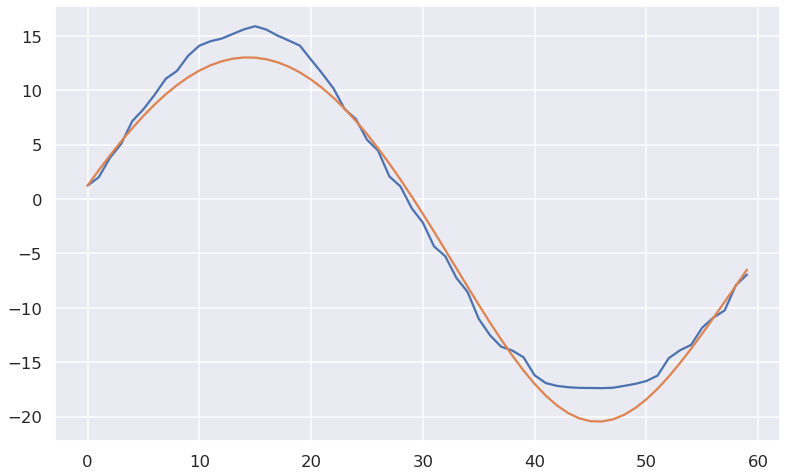

0.0 0.0285 0.028


KeyboardInterrupt: 

In [26]:
images = np.zeros((31, 61, 121))
nearfield_amp = np.zeros(31)
nearfield_phase = np.zeros(31)

for n in np.arange(0, 31, 1):

    #data_array = np.zeros((60, 32758), np.complex128)

    select_antennas = np.arange(0, 120, 2)
    # channel 0-30 from antenna 1
    # channel 30-60 from antenna 3

    data_array = file['range3cm_step1mm_z0mm'][f'{n}'][select_antennas, :, 8192: 8192 + 2*4096]
    #data_array[30:, :] = file['range3cm_step1mm_z0mm'][f'{n}'][select_antennas[0:30], 3, :]

    #data_array = data_array.reshape((data_array.shape[0], 1, data_array.shape[-1]))
    #print(data_array.shape)
    #data_array = data_array[:, :, 0:8192]
    x = np.linspace(-0.010, 0.010, 21)
    y = np.linspace( -0.010, 0.045, 21)

    summed_data, nearfield_param = SumData(data_array, x, y, 1, n * 0.001, antispiral=True, )
    
    nearfield_amp[n], nearfield_phase[n] = nearfield_param[0], nearfield_param[1]
    
    image = np.mean(abs(summed_data) ** 2, axis = -1)

    max_position = np.unravel_index(np.argmax(image), (x.size, y.size))
    
    x_max, y_max = x[max_position[0]], y[max_position[1]]
    
    print(np.round(x_max, 5), np.round(y_max, 5), n * 0.001)
    
    #images[n] = image
    
    #sns.set_theme(style='ticks', context='talk')
    #cmap = sns.color_palette('plasma', as_cmap=True)

    #fig = plt.figure(figsize=(10, 8))
    #ax = fig.add_subplot(1,1,1)


    #img = ax.imshow(
    #    image,
    #    aspect='auto',
    #    cmap=cmap,
    #    extent=(-0.05, 0.05, 0.05, -0.05),
    #)
    #cbar = fig.colorbar(img, label=r'$|V_{rms}^2|$')
    #ax.set_xlabel('X-Position (m)')
    #ax.set_ylabel('Y-Position (m)')

    #plt.tight_layout()
    #plt.show()


Text(0, 0.5, 'Y-Position (m)')

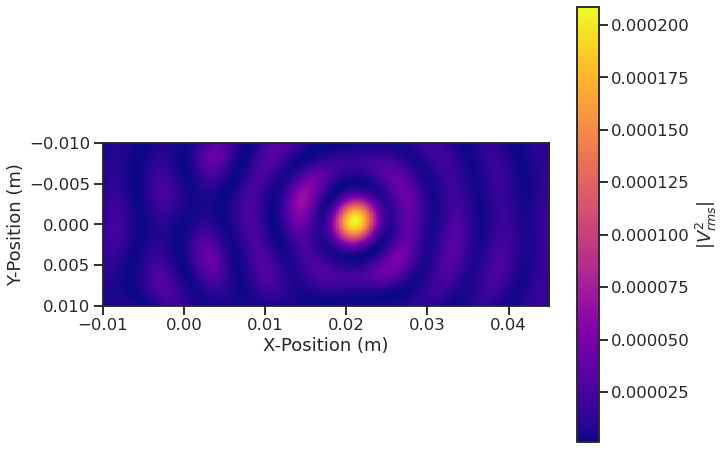

In [8]:
sns.set_theme(style='ticks', context='talk')
cmap = sns.color_palette('plasma', as_cmap=True)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(1,1,1)

img = ax.imshow(
    images[21],
    aspect=1,
    cmap=cmap,
    extent=(-0.01, 0.045, 0.01, -0.01),
)
cbar = fig.colorbar(img, label=r'$|V_{rms}^2|$')
ax.set_xlabel('X-Position (m)')
ax.set_ylabel('Y-Position (m)')



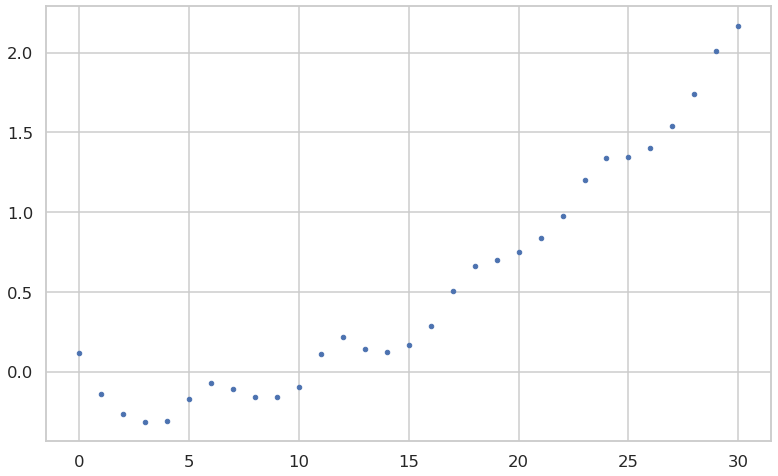

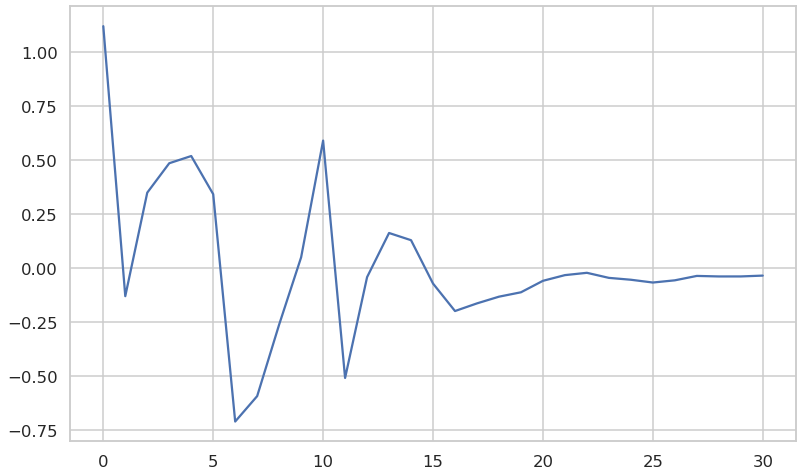

In [9]:
sns.set_theme(style='whitegrid', context='talk')
cmap = sns.color_palette('plasma', as_cmap=True)

fig = plt.figure(figsize=(13, 8))
ax = fig.add_subplot(1,1,1)

ax.plot(nearfield_amp[0:], '.')

sns.set_theme(style='whitegrid', context='talk')
cmap = sns.color_palette('plasma', as_cmap=True)

fig = plt.figure(figsize=(13, 8))
ax = fig.add_subplot(1,1,1)

ax.plot(nearfield_phase)

# fit gaussian to peak

In [ ]:
def gaussian2d(x, x0, y0, a, b, c, d):
    
    g = d * np.exp(-1 * (((x[0]-x0)/a)**2 + ((x[1]-y0)/b)**2 + ((x[0]-x0)*(x[1]-y0)/c)))
    #print(g.shape)
    
    return g.ravel()

In [ ]:
i_image = 5

peak_max = np.unravel_index(np.argmax(images[i_image]), (61, 121))

print(peak_max, np.round(x[peak_max[0]], 5), np.round(y[peak_max[1]], 5))

In [ ]:
delta = 11

sns.set_theme(style='ticks', context='talk')
cmap = sns.color_palette('plasma', as_cmap=True)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(1,1,1)

img = ax.imshow(
    images[i_image][peak_max[0]-delta:peak_max[0]+delta, peak_max[1]-delta:peak_max[1]+delta],
    aspect='auto',
    cmap=cmap,
    extent=(y[peak_max[1]-delta],y[peak_max[1]+delta], x[peak_max[0]+delta], x[peak_max[0]-delta]),
)
cbar = fig.colorbar(img, label=r'$|V_{rms}^2|$')
ax.set_xlabel('X-Position (m)')
ax.set_ylabel('Y-Position (m)')



# loop over the images, extract gaussian fit parameters

In [ ]:
popt_list = []
pcov_list = []

for i_image in np.arange(0, 31, 1):
    
    peak_max = np.unravel_index(np.argmax(images[i_image]), (61, 121))

    x_grid, y_grid = np.meshgrid(x[peak_max[0]-delta:peak_max[0]+delta], y[peak_max[1]-delta:peak_max[1]+delta])
    subimage = images[i_image][peak_max[0]-delta:peak_max[0]+delta, peak_max[1]-delta:peak_max[1]+delta]


    #print(x_grid.max(), x_grid.min(), y_grid.max(), y_grid.min())

    x_range = (x_grid.max() - x_grid.min())
    y_range = (y_grid.max() - y_grid.min())

    y_center = np.round(y[peak_max[1]], 5) #x_grid.min() + (x_grid.max() - x_grid.min()) / 2
    x_center = np.round(x[peak_max[0]], 5) #y_grid.min() + (y_grid.max() - y_grid.min()) / 2
    peak_val = np.max(subimage)

    #print(y_center, x_center, (x_range/4)**2, (y_range/4)**2)

    popt, pcov = scipy.optimize.curve_fit(
        gaussian2d, 
        (y_grid.flatten(), x_grid.flatten()),
        subimage.ravel(),
        [y_center, x_center, 1e-3, 1e-3, 1e-5, peak_val],
    )
    
    popt_list.append(popt)
    pcov_list.append(pcov)

popt_list = np.array(popt_list)
pcov_list = np.array(pcov_list)
print(popt_list[11] - popt_list[0])
print(np.sqrt(np.diag(pcov_list[10])))

pos_err = []
for i in range(pcov_list.shape[0]):
    pos_err.append(np.sqrt(pcov_list[i][0,0]))
pos_err = np.array(pos_err)
#print(pcov)

In [ ]:
mean_width = np.mean(popt_list[:, 2:4], axis=1)
# mean_width = (sqrt(2) * sigma)
# FWHM = 2 * sqrt(2 * log(2)) * sigma
# FWHM = 2 * sqrt(log(2)) * mean_width


fwhm = mean_width * 2 * np.sqrt(2*np.log(2))

In [ ]:
sns.set_theme(style='whitegrid', context='talk', palette='deep', font_scale=1.2)
clist = sns.color_palette('deep', n_colors=10)


fig = plt.figure(figsize=(13, 8))
ax = fig.add_subplot(1,1,1)

#ax.plot(np.arange(0, 31, 1) * 0.001, popt_list[:, 0], marker='.')
#ax.fill_between(
#    np.arange(0, 31, 1) * 0.001, 
#    popt_list[:, 0]-mean_width/np.sqrt(2),
#    popt_list[:, 0]+mean_width/np.sqrt(2),
#    alpha=0.2
#)
rms_deviation = np.sqrt(np.mean((popt_list[:, 0]*1000 - np.arange(0, 31, 1) )**2))

ax.plot(
    np.arange(0, 31, 1) * 1, 
    np.arange(0, 31, 1) * 1,
    label='Target Position',
    color=clist[1]
)

ax.plot(np.arange(0, 31, 1) * 1, 
       popt_list[:, 0]*1000,  
        marker='.',
        label='Reconstructed Position',
        linestyle='none',
        color=clist[0]
       )

#ax.errorbar(x=np.arange(0, 31, 1) * 1, 
#        y=popt_list[:, 0]*1000,
#        yerr=1000*pos_err * 50,
#        marker='.',
#        label='Reconstructed Position',
#        linestyle='none',
#        color=clist[0]
#       )

ax.legend(loc=0)

#ax.text(8, 2, f'RMS Position Deviation = {np.round(rms_deviation,1)} mm')

ax.set_xlabel('Target Position (mm)')
ax.set_ylabel('Reconstructed Position (mm)')
ax.set_title('SYNCA Position Reconstruction')

#plt.tight_layout()

name = '220920_synca_radial_position_reconstruction_sweep'

savepath = pathlib.Path.home()/'group'/'project'/'plots'/'analysis'/'beamforming'

plt.savefig(savepath/name, dpi=128)



In [ ]:

sns.set_theme(style='whitegrid', context='talk', palette='deep', font_scale=1.2)
cmap = sns.color_palette('plasma', as_cmap=True)
fig = plt.figure(figsize=(13, 8))

ax = fig.add_gridspec(top=0.95, right=0.75).subplots()
#sns.jointplot(
#    data = {'x':np.arange(0, 31, 1), 'y':popt_list[:, 0]*1000 - np.arange(0, 31, 1)},
#    x='x',
#    y='y',
#)

#ax.plot(np.arange(0, 31, 1) * 1, 
#        popt_list[:, 0]*1000 - np.arange(0, 31, 1),
#        '.',
#       )

ax.errorbar(x=np.arange(0, 31, 1) * 1, 
        y=popt_list[:, 0]*1000 - np.arange(0, 31, 1),
        yerr=1000*pos_err * 1,
        marker='.',
        label='Reconstructed Position',
        linestyle='none',
        color=clist[0],
        capsize=2
       )

ax_hist = ax.inset_axes([1.05, 0, 0.25, 1], sharey=ax)
ax_hist.tick_params(axis='y', labelleft=False)

hist = ax_hist.hist(popt_list[:, 0]*1000 - np.arange(0, 31, 1), orientation='horizontal', bins=12)
#xlims = ax.get_xlim()

#ax.fill_between(
#    np.arange(-2, 33, 1),
#    -np.std(popt_list[:, 0]*1000 - np.arange(0, 31, 1)), 
#    np.std(popt_list[:, 0]*1000 - np.arange(0, 31, 1)),
#    color=clist[1],
#    alpha=0.5,
#    label=r'$\pm1\sigma$'
#)

#ax.fill_between(
#    np.arange(-2, 33, 1),
#    -np.mean(fwhm*1000)/4, 
#    np.mean(fwhm*1000)/4,
#    color=clist[2],
#    alpha=0.5,
#    label=r'HWHM'
#)

#ax.errorbar(31,0, yerr=np.mean(fwhm*1000)/4, color=clist[2], capsize=10, capthick=2, label='HWHM', linestyle='none')
#ax.set_xlim(xlims[0], 32)
ax.set_xlabel('Target Position (mm)')
ax.set_ylabel('Difference from Target Position (mm)')
ax_hist.set_xlabel('N')
ax_hist.set_xticks(np.arange(0, 7, 1))
ax.set_title('SYNCA Position Reconstruction Error')
#ax.legend(loc=2)

#plt.tight_layout()

name = '220920_synca_reconstruction_sweep_errors'

savepath = pathlib.Path.home()/'group'/'project'/'plots'/'analysis'/'beamforming'

plt.savefig(savepath/name, dpi=128)


print(np.sqrt(np.mean((popt_list[:, 0]*1000 - np.arange(0, 31, 1))**2)))
print(np.mean(pos_err))

In [ ]:
sns.set_theme(style='whitegrid', context='talk', palette='deep')
cmap = sns.color_palette('plasma', as_cmap=True)

fig = plt.figure(figsize=(13, 8))
ax = fig.add_subplot(1,1,1)

ax.hist(popt_list[:, 0]*1000 - np.arange(0, 31, 1), 9)

print(np.std(popt_list[:, 0]*1000 - np.arange(0, 31, 1)))

#ax.plot(np.arange(0, 31, 1) * 0.001, popt_list[:, 0], marker='.')
#ax.fill_between(
#    np.arange(0, 31, 1) * 0.001, 
#    popt_list[:, 0]-mean_width/np.sqrt(2),
#    popt_list[:, 0]+mean_width/np.sqrt(2),
#    alpha=0.2
#)


#ax.plot(np.arange(0, 31, 1) * 0.001, np.arange(0, 31, 1) * 0.001)

In [ ]:
gauss = gaussian2d((y_grid.flatten(), x_grid.flatten()), *popt).reshape((2*delta, 2*delta))

sns.set_theme(style='ticks', context='talk')
cmap = sns.color_palette('plasma', as_cmap=True)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(1,1,1)

img = ax.imshow(
    gauss,
    aspect='auto',
    cmap=cmap,
    extent=(y[peak_max[1]-delta],y[peak_max[1]+delta], x[peak_max[0]+delta], x[peak_max[0]-delta]),
)
cbar = fig.colorbar(img, label=r'$|V_{rms}^2|$')
ax.set_xlabel('X-Position (m)')
ax.set_ylabel('Y-Position (m)')

In [ ]:
sns.set_theme(style='ticks', context='talk')
cmap = sns.color_palette('plasma', as_cmap=True)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(1,1,1)


img = ax.imshow(
    image,
    aspect='auto',
    cmap=cmap,
    extent=(-0.05, 0.05, 0.05, -0.05),
)
cbar = fig.colorbar(img, label=r'$|V_{rms}^2|$')
ax.set_xlabel('X-Position (m)')
ax.set_ylabel('Y-Position (m)')

plt.tight_layout()
save_path = pathlib.Path.home()/'group'/'project'/'plots'/'analysis'/'antenna'/'cyclotron_emitter'
name = '220418_25mm_beamforming_corrected_no_antispiral'

#plt.savefig(save_path/name)